# Sudoku solver

In classic Sudoku, the objective is to fill a 9 × 9 grid with digits so that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid (also called "boxes", "blocks", or "regions") contains all of the digits from 1 to 9.

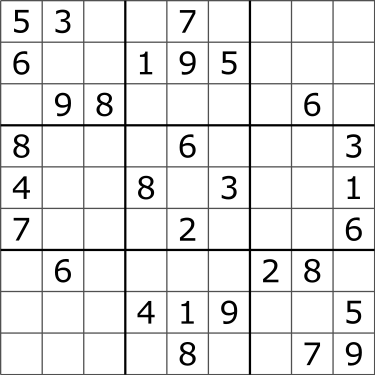

## Prepare environment

In [1]:
import sys
import os

project_root = os.getcwd()
src_dir = os.path.join(project_root, "src")
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

# TODO: how to get rid of src (this is the only way VS Code resolves it)
from src.sudoku_solver.data.dataset import prepare_dataset
from src.sudoku_solver.data.preprocess import preprocess_input, preprocess_target
from src.sudoku_solver.model.model import prepare_model
from src.sudoku_solver.model.training import prepare_callbacks
from src.sudoku_solver.model.evaluation import plot_histories

import numpy as np
import tensorflow as tf
import keras

# Enable mixed precision training to speed up computation
# WARNING: turn off if you run this on CPU - it will significantly slow down training
# https://keras.io/api/mixed_precision/
# 
# Enable when training takes too long - it lowered training time by 14% and increased error rate by 16%
# keras.mixed_precision.set_global_policy("mixed_float16")

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
# tf.config.experimental.enable_op_determinism()

MODEL_FILE_NAME = "sudoku_solver.keras"

2025-04-28 21:45:17.904086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745869517.926016  164904 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745869517.932476  164904 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 21:45:17.955321: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Hyperparameters

In [2]:
DATA_SIZE_LIMIT = 20_000

BATCH_SIZE = 256 # Best accurracy & time for current learning rate
LEARNING_RATE = 1e-3
EPOCHS = 3

# Use residual connections in convolutional model architecture
USE_RESIDUAL = True

# Idea is to pretrain model on solution-only data (self-supervised learning) like autoencoder
#
# Note: There is no performance improvement on small data sample (10%) and few epochs training (1)
# Turn on when training with more data and epochs to see if it helps
USE_PRE_TRAINING = False

USE_DISK_CACHE = False

## Prepare dataset

In [3]:
train_datasets, val_dataset, test_dataset = prepare_dataset(BATCH_SIZE, size_limit=DATA_SIZE_LIMIT, use_disk_cache=USE_DISK_CACHE)

Trying to prepare dataset from disk
Serialized data folder ./sudoku_tfrecords/train_00 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_01 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_02 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_03 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_04 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_05 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_06 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_07 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_08 not found or empty.
Serialized data folder ./sudoku_tfrecords/train_09 not found or empty.
Serialized data folder ./sudoku_tfrecords/val not found or empty.
Serialized data folder ./sudoku_tfrecords/test not found or empty.
Pre-processed sudoku data not found on disk. Downloading new version...
Path to dataset files: /home/martin/.cache/kaggle

I0000 00:00:1745869528.827726  164904 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


Decoded CSV shape: (2, 9000000)
Download complete. Starting preprocess...
Original difficulty distribution: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  140  158  207  250  307  335  427  510  590  692  829  925 1024 1108
 1271 1358 1422 2080 1368 1307 1208  893  711  456  291  133]
Train difficulty distribution (percentage): [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.7   0.79  1.04  1.25  1.54  1.67  2.14  2.55
  2.95  3.46  4.15  4.63  5.12  5.54  6.35  6.79  7.11 10.4   6.84  6.54
  6.04  4.46  3.55  2.28  1.45  0.66]
Val difficulty distribution (percentage): [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.8  0.8  1.   1.4  1.4  1.6  2.   2.6  3.   3.4  4.   4.6  5.2

2025-04-28 21:46:11.632001: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


./sudoku_tfrecords/train_00 1900


2025-04-28 21:46:12.087156: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


./sudoku_tfrecords/train_01 1900
./sudoku_tfrecords/train_02 1900


2025-04-28 21:46:13.142366: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


./sudoku_tfrecords/train_03 1900
./sudoku_tfrecords/train_04 1900
./sudoku_tfrecords/train_05 1900
./sudoku_tfrecords/train_06 1900


2025-04-28 21:46:15.026858: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


./sudoku_tfrecords/train_07 1900
./sudoku_tfrecords/train_08 1900
./sudoku_tfrecords/train_09 1900
./sudoku_tfrecords/val 500
./sudoku_tfrecords/test 500
Dataset ready.


Measuring pipeline performance...:   1%|          | 7/1000 [00:00<00:18, 54.04it/s]

Average batch fetch time is: 0.14364123344421387


In [4]:
print("Validate test dataset pipeline:\n")
for X_batch, y_batch in train_datasets[0].take(1):
    for X, y in zip(X_batch, y_batch):
        # TODO: can't we reuse this conversion back to readable Sudoku puzzle? (e.g. invert operation)
        print(((X + 0.5) * 9).numpy().reshape((9, 9)))
        print((y + 1).numpy().reshape((9, 9)))
        break

Validate test dataset pipeline:

[[0. 0. 0. 5. 4. 8. 3. 0. 0.]
 [2. 5. 6. 9. 7. 3. 0. 1. 0.]
 [3. 0. 8. 0. 0. 0. 5. 0. 7.]
 [5. 2. 0. 0. 9. 0. 1. 8. 0.]
 [9. 1. 0. 4. 0. 2. 7. 0. 0.]
 [8. 6. 7. 3. 0. 1. 4. 2. 9.]
 [0. 0. 5. 1. 2. 4. 9. 7. 0.]
 [1. 7. 2. 8. 0. 9. 6. 0. 5.]
 [4. 0. 9. 0. 6. 5. 2. 0. 1.]]
[[7 9 1 5 4 8 3 6 2]
 [2 5 6 9 7 3 8 1 4]
 [3 4 8 2 1 6 5 9 7]
 [5 2 4 6 9 7 1 8 3]
 [9 1 3 4 8 2 7 5 6]
 [8 6 7 3 5 1 4 2 9]
 [6 3 5 1 2 4 9 7 8]
 [1 7 2 8 3 9 6 4 5]
 [4 8 9 7 6 5 2 3 1]]


In [5]:
train_batch_size = sum(1 for _ in train_datasets[0])
train_batch_size

7

## Train model

### Prepare model

In [21]:
model = prepare_model(use_residual=USE_RESIDUAL, learning_rate=LEARNING_RATE)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 9, 9, 64)  │        640 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 9, 9, 64)  │     36,928 │ activation_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 9, 9, 64)  │     36,928 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 9, 9, 64)  │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 9, 9, 64)  │     36,928 │ activation_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 9, 9, 64)  │     36,928 │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 9, 9, 64)  │          0 │ add_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,944,713 (30.31 MB)

 Trainable params: 7,943,049 (30.30 MB)

 Non-trainable params: 1,664 (6.50 KB)

### Train

In [22]:
histories = []
for train_dataset in train_datasets:
    training_callbacks = prepare_callbacks()

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=training_callbacks,
    )
    histories.append(history)

Epoch 1/3


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 710ms/step - accuracy: 0.1132 - loss: 3.5172 - val_accuracy: 0.1186 - val_loss: 2.3338 - learning_rate: 0.0010
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 428ms/step - accuracy: 0.1585 - loss: 2.8401 - val_accuracy: 0.1122 - val_loss: 2.3332 - learning_rate: 0.0010
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 0.2284 - loss: 2.3100 - val_accuracy: 0.1146 - val_loss: 2.3350 - learning_rate: 0.0010
Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - accuracy: 0.1316 - loss: 2.6725 - val_accuracy: 0.1162 - val_loss: 2.3333 - learning_rate: 0.0010
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - accuracy: 0.1718 - loss: 2.4208 - val_accuracy: 0.1129 - val_loss: 2.3349 - learning_rate: 0.0010
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step - accuracy: 0.2406 - loss: 2.1944 - val_accuracy: 0.1141 - val_loss: 2.3372 - learning_rate: 0.0010
Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step - accuracy: 0.1396 - loss: 2.5431 - val_accuracy: 0.1142 - val_los

### Save model

In [23]:
model.save(MODEL_FILE_NAME)

## Evaluate model

### Plot training history as learning curves

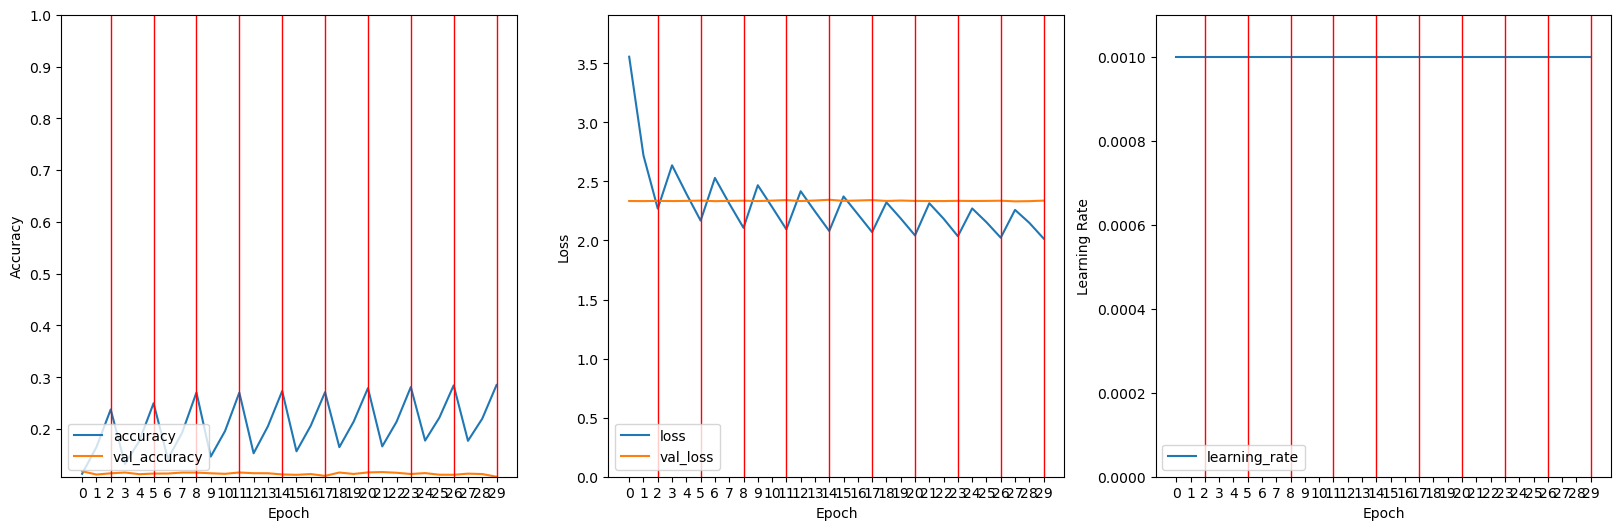

In [25]:
plot_histories(histories)

### Load model from disk to get reproducible results

In [26]:
model = keras.saving.load_model(MODEL_FILE_NAME)

### Evaluate selected puzzles

In [27]:
def prepare_input_batch(puzzle):
    reshaped = preprocess_input(puzzle)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [28]:
def prepare_target_batch(solution):
    reshaped = preprocess_target(solution)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [29]:
def solve_sudoku(puzzle):
    reshaped_batch = prepare_input_batch(puzzle)
    predictions = model.predict(reshaped_batch)
    result = np.argmax(predictions, axis=-1) + 1 # predictions are 0-based but game starts with 1
    return result

In [30]:
result = solve_sudoku(
    ""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
).reshape((9,9))

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
[[2 3 5 7 4 6 7 3 3]
 [3 8 6 7 8 1 4 3 8]
 [7 6 5 1 8 4 7 1 6]
 [8 5 3 2 7 3 7 3 8]
 [6 6 9 8 2 5 8 6 7]
 [8 4 5 2 4 1 6 7 6]
 [5 5 1 3 7 3 1 2 1]
 [2 3 5 9 9 4 4 3 8]
 [5 1 6 1 6 2 7 7 3]]


In [31]:
puzzle = (""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
)
solution = (""
    "863259714"
    "425167938"
    "791438265"
    "612845397"
    "984673152"
    "357912846"
    "548791623"
    "176324589"
    "239586471"
)

accuracy, loss = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))

W0000 00:00:1745870338.299716  165008 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1111 - loss: 2.3408


In [32]:
result = solve_sudoku(""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
).reshape((9,9))

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[2 3 4 7 4 3 7 3 3]
 [3 8 6 7 8 1 1 9 8]
 [7 6 5 3 8 4 7 1 6]
 [8 5 3 2 7 3 7 3 8]
 [6 1 9 8 2 1 8 6 7]
 [8 4 5 2 4 7 6 7 6]
 [5 5 1 3 7 3 1 2 1]
 [2 3 5 9 9 4 4 3 8]
 [5 1 4 1 6 2 7 7 3]]


In [33]:
puzzle = (""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
)

solution = (
    ""
    "482519637"
    "156347829"
    "379826541"
    "835961274"
    "627483915"
    "914752368"
    "268175493"
    "591234786"
    "743698152"
)

loss, accuracy = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))
accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0741 - loss: 2.3395


0.07407407462596893

### Evaluate test set performance

In [34]:
loss, accuracy = model.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1157 - loss: 2.3333


In [35]:
print(f"On test set, model achieved accuracy: {accuracy} and loss: {loss}")

On test set, model achieved accuracy: 0.11574074625968933 and loss: 2.3333168029785156


The End